In [1]:
import os
import skimage.io as io
import imageio
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Import TensorFlow and enable eager execution

In [2]:
import tensorflow as tf
tf.enable_eager_execution()

## Settings

In [3]:
COCO_ROOT = '/data/COCO/'
WEIGHT_DECAY = 0.0005
TRAIN_BATCH_SIZE = 16
VAL_BATCH_SIZE = 16
TRAIN_EPOCHS = 45
INPUT_SIZE = 384
LEARNING_RATE = 0.0001
LOG_DIR = 'logs/person_coco_aspp'

## Import COCO API

In [4]:
import sys
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

## Dataset base class

In [5]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

## COCO Dataset subclass

In [6]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

## Create train and validation datasets

In [7]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

train_ds = COCO_dataset_train.train_dataset(
    TRAIN_BATCH_SIZE, TRAIN_EPOCHS, INPUT_SIZE)
val_ds = COCO_dataset_val.val_dataset(
    VAL_BATCH_SIZE, INPUT_SIZE)

loading annotations into memory...
Done (t=11.50s)
creating index...
index created!
loading annotations into memory...
Done (t=0.37s)
creating index...
index created!
Instructions for updating:
Colocations handled automatically by placer.


## Submodel: Convolution+BatchNorm+ReLU

In [8]:
class CBR(tf.keras.Model):
    def __init__(self, filters, kernel_size, **conv_params):
        super(CBR, self).__init__()
        self.conv = tf.layers.Conv2D(filters, kernel_size, activation=None, use_bias=False, **conv_params)
        self.bn = tf.layers.BatchNormalization(axis=-1)

    def __call__(self, inp, is_training=False):
        out = self.conv(inp)
        out = self.bn(out, training=is_training)
        out = tf.nn.relu(out)
        return out

## Submodel: ASPP, inspired by Atrous Spatial Pyramid Pooling

In [9]:
class ASPP(tf.keras.Model):
    def __init__(self, **conv_params):
        super(ASPP, self).__init__()
        self.conv_1 = CBR(256, (1, 1), **conv_params)
        self.conv_2 = CBR(256, (3, 3), dilation_rate=6, **conv_params)
        self.conv_3 = CBR(256, (3, 3), dilation_rate=12, **conv_params)
        self.conv_4 = CBR(256, (3, 3), dilation_rate=18, **conv_params)
        self.conv_5 = CBR(256, (1, 1), **conv_params)

    def __call__(self, inp, is_training=False):
        out_1 = self.conv_1(inp, is_training)
        out_2 = self.conv_2(inp, is_training)
        out_3 = self.conv_3(inp, is_training)
        out_4 = self.conv_4(inp, is_training)

        out = tf.concat([out_1, out_2, out_3, out_4], axis=3)
        out = self.conv_5(out, is_training)

        return out

## Main network definition

In [10]:
class Model(tf.keras.Model):
    def __init__(self, weight_decay=0.0):
        super(Model, self).__init__()

        conv_params = {
            'padding': 'same',
            'kernel_regularizer': tf.keras.regularizers.l2(weight_decay)
        }

        self.conv_1 = CBR(64, (3, 3), **conv_params)
        self.conv_2 = CBR(64, (3, 3), **conv_params)
        self.conv_3 = CBR(128, (3, 3), **conv_params)
        self.conv_4 = CBR(128, (3, 3), **conv_params)
        self.conv_5 = CBR(256, (3, 3), **conv_params)
        self.conv_6 = CBR(256, (3, 3), **conv_params)
        self.conv_7 = CBR(512, (3, 3), **conv_params)
        self.conv_8 = CBR(512, (3, 3), **conv_params)
        self.conv_9 = CBR(512, (3, 3), **conv_params)
        self.conv_10 = CBR(512, (3, 3), **conv_params)

        self.conv_11 = CBR(48, (1, 1), **conv_params)
        self.conv_12 = CBR(256, (3, 3), **conv_params)
        self.conv_13 = CBR(256, (3, 3), **conv_params)
        self.conv_14 = tf.layers.Conv2D(1, (1, 1), activation=None, padding='same')

        self.maxpool = tf.layers.MaxPooling2D((2, 2), (2, 2), padding='same')

        self.aspp = ASPP(**conv_params)

    def __call__(self, inp, is_training=False):

        out = self.conv_1(inp, is_training)
        out = self.conv_2(out, is_training)
        out = self.maxpool(out)
        out = self.conv_3(out, is_training)
        out = self.conv_4(out, is_training)
        out = self.maxpool(out)
        out = self.conv_5(out, is_training)
        out = self.conv_6(out, is_training)
        out_enc_mid = out
        out = self.maxpool(out)
        out = self.conv_7(out, is_training)
        out = self.conv_8(out, is_training)
        out = self.maxpool(out)
        out = self.conv_9(out, is_training)
        out = self.conv_10(out, is_training)

        out = self.aspp(out, is_training)

        out = tf.image.resize_bilinear(out, tf.shape(out_enc_mid)[1:3])

        out_enc_mid = self.conv_11(out_enc_mid, is_training)

        out = tf.concat([out, out_enc_mid], axis=3)

        out = self.conv_12(out, is_training)
        out = self.conv_13(out, is_training)
        out = self.conv_14(out)

        out = tf.image.resize_bilinear(out, tf.shape(inp)[1:3])

        return out

## Create the network

In [11]:
net = Model(weight_decay=WEIGHT_DECAY)

## Loss function and validation evaluation

In [12]:
def loss(logits, labels):
    return tf.losses.sigmoid_cross_entropy(labels, logits)

def evaluate_model(net, val_ds):
    val_ds_iterator = val_ds.make_one_shot_iterator()
    mean_loss = 0.0
    counter = 0
    for (img, gt) in val_ds_iterator:
        logits = net(img, is_training=False)
        mean_loss += loss(logits, gt)
        counter += 1
    mean_loss /= counter
    return mean_loss

## Create training structures

In [13]:
train_ds_iterator = train_ds.make_one_shot_iterator()

optimizer = tf.train.AdamOptimizer(LEARNING_RATE)
writer = tf.contrib.summary.create_file_writer(LOG_DIR)
global_step = tf.train.get_or_create_global_step()

ckpt_prefix = os.path.join(LOG_DIR, 'ckpt')
ckpt = tf.train.Checkpoint(optimizer=optimizer, model=net, gs=global_step)
ckpt_manager = tf.train.CheckpointManager(ckpt, ckpt_prefix, max_to_keep=5)
if ckpt_manager.latest_checkpoint is not None:
    print('Restoring from checkpoint: {}'.format(ckpt_manager.latest_checkpoint))
    ckpt.restore(ckpt_manager.latest_checkpoint)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



## Run training loop

In [14]:
for (img, gt) in train_ds_iterator:

    gs = global_step.numpy()

    # Forward
    with tf.GradientTape() as tape:
        logits = net(img, is_training=True)
        loss_value = loss(logits, gt) + sum(net.losses)

    # Bacward
    grads = tape.gradient(loss_value, net.variables)
    optimizer.apply_gradients(zip(grads, net.variables), global_step=global_step)

    # Display loss and images
    if gs % 100 == 0:
        with writer.as_default():
            with tf.contrib.summary.always_record_summaries():
                tf.contrib.summary.scalar('loss', loss_value)
                tf.contrib.summary.image('seg', tf.concat([gt, tf.sigmoid(logits)], axis=2))
        print("[%4d] Loss: %2.4f" % (gs, loss_value))

    # Calc validation loss
    if gs % 200 == 0:
        val_loss = evaluate_model(net, val_ds)
        with writer.as_default():
            with tf.contrib.summary.always_record_summaries():
                tf.contrib.summary.scalar('val_loss', val_loss)
        print("[%4d] Validation Loss: %2.4f" % (gs, val_loss))

    # Save checkpoint
    if gs % 1000 == 0:
        ckpt_manager.save()

ckpt_manager.save()

Instructions for updating:
Use tf.cast instead.
[   0] Loss: 3.7347
[   0] Validation Loss: 0.6938
[ 100] Loss: 2.6420
...


## Inference parameters

In [15]:
CKPT_DIR = 'logs/person_coco_aspp/ckpt'
INPUT_IMG_FPATH = 'img/me_512.png'
OUTPUT_IMG_FPATH = 'img/me_512_seg.png'

## Create inference model and restore from a checkpoint

In [16]:
net = Model()

ckpt = tf.train.Checkpoint(model=net)
ckpt.restore(tf.train.latest_checkpoint(CKPT_DIR))

## Load input image and run throught the netwwork

In [17]:
img = imageio.imread(INPUT_IMG_FPATH)
img = img[None, ...].astype(np.float32) / np.float32(255.)

logits = net(img, is_training=False)
img_out = tf.sigmoid(logits).numpy()
img_out = np.round(img_out[0, ...] * 255.).astype(np.uint8)

## Display input image and output segmentation

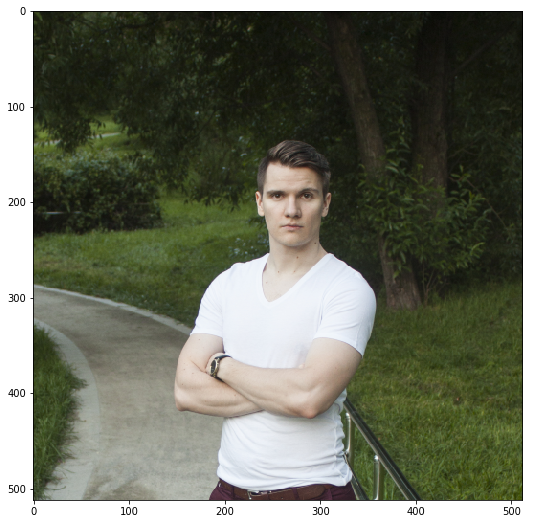

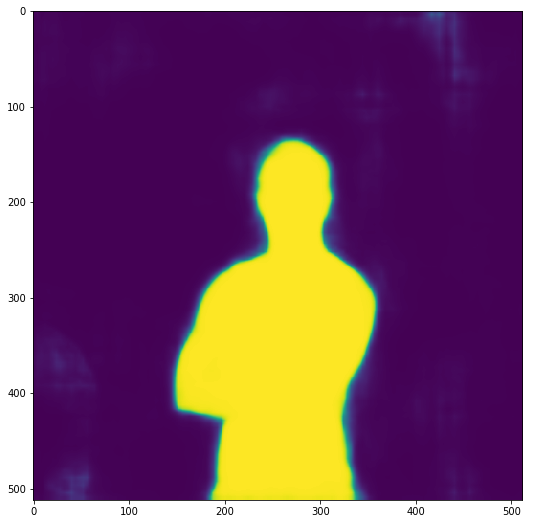

In [18]:
plt.figure(figsize=[9, 9]); _=plt.imshow(img[0, ...])
plt.figure(figsize=[9, 9]); _=plt.imshow(img_out[..., 0])

## Save segmentation image

In [19]:
imageio.imsave(OUTPUT_IMG_FPATH, img_out)